In [1]:
import subprocess
from dotenv import load_dotenv
import os
import sys

from model.stock_data import fetch_stock_data, preprocess_data # model package contains useful model training functions
from model.model import create_model, create_sequences
from json_manage import json_state, data_file # edit the fastapi state, data file
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from pandas import DataFrame as DF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


load_dotenv()
cwd = os.getenv("CWD")
print(cwd)

#fastapi_process = subprocess.Popen(["uvicorn", "main:app", "--reload"], cwd=cwd)
#streamlit_process = subprocess.Popen(["streamlit", "run", "streamlit/app.py"])

json_state.set_state("training")

ticker_name = "NVDA"
time_period = 31 # days used to create sliding window

# Fetch and preprocess data
try:
    print("Fetching stock data")
    data = fetch_stock_data(ticker_name)
    data = preprocess_data(data)
except:
    print("Error - stock data")
    sys.exit()

#data.plot.line(y='Close', use_index=True)
#plt.show()

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = DF(scaler.fit_transform(data), columns=data.columns)

#ic(scaled_data.head())

predictors = list(data.columns)
train = ["+1d","+7d"]

for col in train:
    predictors.remove(col)


predictors_scaled_df = scaled_data[predictors]
train_scaled_df = scaled_data[train]

print(predictors_scaled_df.head(), train_scaled_df.head())


x_train, x_test, y_train, y_test = train_test_split(np.array(predictors_scaled_df), np.array(train_scaled_df),
                                                    test_size=0.2, random_state=1)


x_train_sequences = create_sequences(x_train, time_period)
y_train_sequences = create_sequences(y_train, time_period)
x_test_sequences = create_sequences(x_test, time_period)
y_test_sequences = create_sequences(y_test, time_period)

print(x_train_sequences.shape, y_train_sequences.shape)

input_shape = x_train_sequences.shape # samples, timesteps, features

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model = create_model(input_shape)

model_info = model.fit(x_train_sequences, [y_train_sequences[:, :, 0], y_train_sequences[:, :, 1]],
                    epochs=25,
                    batch_size=32,
                    validation_split=0.2,
                    validation_data=(x_test_sequences, [y_test_sequences[:, :, 0], y_test_sequences[:, :, 1]]),
                    callbacks=[early_stopping])

model.save("stock_1,7day_model.keras")


y_test_result = model.predict(x_test_sequences)

# `y_test_result` will be a list of two arrays, each containing the predictions for one of the outputs
y_test_result_1d = y_test_result[0]  # Predictions for +1d
y_test_result_7d = y_test_result[1]  # Predictions for +7d

y_test_sequences_reduced = y_test_sequences[:, -1, :] # reduce the sequence dimension, take +1d and +7d at last index

# Calculate accuracy metrics
y_test_actual_1d = y_test_sequences_reduced[:, 0]  # Actual values for +1d from the test set
y_test_actual_7d = y_test_sequences_reduced[:, 1]  # Actual values for +7d from the test set

mse_1d = mean_squared_error(y_test_actual_1d, y_test_result_1d)
mae_1d = mean_absolute_error(y_test_actual_1d, y_test_result_1d)
r2_1d = r2_score(y_test_actual_1d, y_test_result_1d)

mse_7d = mean_squared_error(y_test_actual_7d, y_test_result_7d)
mae_7d = mean_absolute_error(y_test_actual_7d, y_test_result_7d)
r2_7d = r2_score(y_test_actual_7d, y_test_result_7d)

print(f'+1d - MSE: {mse_1d:.3e}, MAE: {mae_1d:.3e}, R2: {r2_1d:.3f}')
print(f'+7d - MSE: {mse_7d:.3e}, MAE: {mae_7d:.3e}, R2: {r2_7d:.3f}')




json_state.set_state("trained")


# pause until the processes terminate
#fastapi_process.wait()
#streamlit_process.wait()

2024-07-25 23:56:51.796490: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_result and y_test_sequences_reduced are already defined


# Flatten the predictions and actual values to align them for comparison
y_test_result_1d_flat = y_test_result_1d.flatten()
y_test_result_7d_flat = y_test_result_7d.flatten()
y_test_actual_1d_flat = y_test_actual_1d.flatten()
y_test_actual_7d_flat = y_test_actual_7d.flatten()

# Plot +1d predictions vs actual values
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(y_test_actual_1d_flat, label='Actual +1d')
plt.plot(y_test_result_1d_flat, label='Predicted +1d', linestyle='--')
plt.title('Predicted vs Actual Stock Prices for +1d')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()

# Plot +7d predictions vs actual values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(y_test_actual_7d_flat, label='Actual +7d')
plt.plot(y_test_result_7d_flat, label='Predicted +7d', linestyle='--')
plt.title('Predicted vs Actual Stock Prices for +7d')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
# reconstruct actual and predicted values

actual_stock_values = [y_test_actual_1d_flat, y_test_actual_7d_flat]

predicted_stock_values = [y_test_result_1d_flat, y_test_result_7d_flat]

print(np.array(actual_stock_values).shape, np.array(predicted_stock_values).shape)

from json_manage import data_file
from pandas import DataFrame as DF

data_file.write(np.array(actual_stock_values), np.array(predicted_stock_values))

recalled_test = DF(data_file.read())
recalled_test.info()
print(recalled_test.head(10))



NameError: name 'y_test_result_1d' is not defined

In [3]:
results_df = DF([y_test_result_1d_flat, y_test_result_7d_flat, y_test_actual_1d_flat, y_test_actual_7d_flat]).T
#results_df.to_csv('data.csv', header=['Result 1d', 'Result 7d', 'Real 1d', 'Real 7d'])
results_df.head(10)

NameError: name 'y_test_actual_1d_flat' is not defined

In [11]:
from typing import Tuple
from json_manage import data_file
import numpy as np
import pandas as pd

# Read the data
data: Tuple = data_file.read(mode=2)

# Extract real and predicted values
actual = np.array(data[0])  # Assuming data[0] is an array of real values
predicted = np.array(data[1])  # Assuming data[1] is an array of predicted values

actual_1d = actual[0]
predicted_1d = predicted[0]
actual_7d = actual[1]
predicted_7d = predicted[1]

# Create DataFrames for plotting
df_1d = pd.DataFrame({"Actual": actual_1d, "Predicted": predicted_1d})
df_7d = pd.DataFrame({"Actual": actual_7d, "Predicted": predicted_7d})

print(df_1d.head())

     Actual  Predicted
0  0.213900   0.312544
1  0.220491   0.305074
2  0.277692   0.307970
3  0.025389   0.306107
4  0.250061   0.303243


<Axes: >

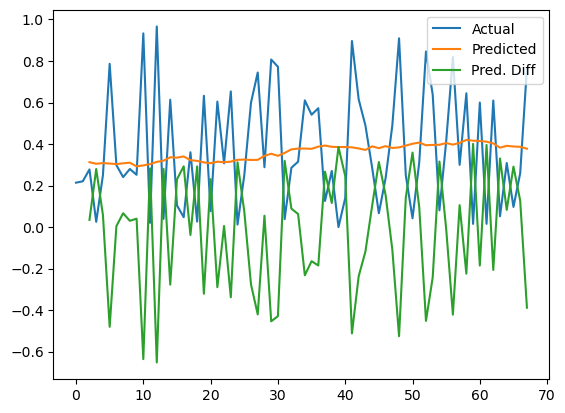

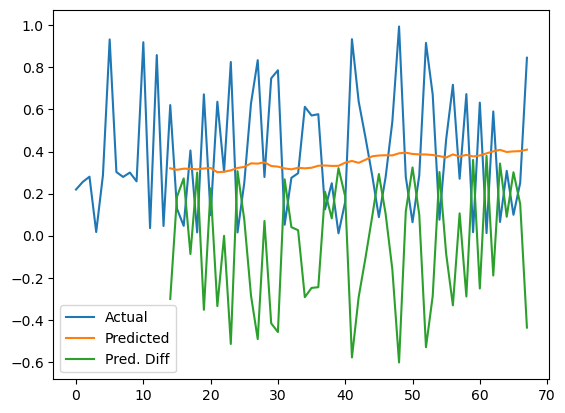

In [13]:
df_1d['Predicted'] = df_1d['Predicted'].shift(1)
df_7d['Predicted'] = df_7d['Predicted'].shift(7)

df_1d['Pred. Diff'] = df_1d['Predicted'] - df_1d['Actual']
df_7d['Pred. Diff'] = df_7d['Predicted'] - df_7d['Actual']

df_1d.plot()
df_7d.plot()